# Seasonal correlations

This notebook checks the correlation observed between the wind stress and SLP's first EOF mode (commonly known as the North Atlantic Oscillation) for all seasons. The NAO shows a strong correlation in winter months, but not so much in others. This notebook may help understand the nature of our repeat year forcing perturbation.

In [4]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36943,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:40761,Total threads: 4
Dashboard: /proxy/36209/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:43927,


In [3]:

## 2. Start and end times
start_year, end_year = '1958', '2019'

## 3. North Atlantic ocean coordinates
x_min, x_max = -100, 10
y_min, y_max = 10, 75

## 4. Constants
m3_to_Sv = 1e6
ρ0 = 1036
neofs = 3
neigs = 3
npcs = 3
r0 = 6.371 * 10**6

## 5. Plotting land boundaries
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

## Creating monthly-mean SLP from JRA forcnig

In [10]:
dir_name = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/psl/gr/v20190429/'
filename = 'psl_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'
psl_allyear = xr.DataArray()
for year in range(1958, 2019):
    psl = xr.open_dataset(dir_name + filename + str(year) + '01010000-' + str(year) + '12312100.nc').psl.resample(time = '1M').mean()
    if(year == 1958):
        psl_allyear = psl
    else:
        psl_allyear = xr.concat([psl_allyear, psl], dim = 'time')
    print(year)

psl_allyear['time'] = psl_allyear['time'].values.astype('datetime64[M]') + np.timedelta64(13, 'D')
psl_allyear.rename('sea-level-pressure').to_netcdf(path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc', 
                                                    mode = 'w', format = "NETCDF4", engine = "netcdf4")

1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


NameError: name 'psl_all_year' is not defined

In [11]:
psl_allyear.rename('SLP').to_netcdf(path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc', 
                                                    mode = 'w', format = "NETCDF4", engine = "netcdf4")

In [ ]:
dir_name = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/tas/gr/v20190429/'
filename = 'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'
tas_allyear = xr.DataArray()
for year in range(1958, 2019):
    tas = xr.open_dataset(dir_name + filename + str(year) + '01010000-' + str(year) + '12312100.nc').tas.resample(time = '1M').mean()
    if(year == 1958):
        tas_allyear = tas
    else:
        tas_allyear = xr.concat([tas_allyear, tas], dim = 'time')
    print(year)

tas_allyear['time'] = tas_allyear['time'].values.astype('datetime64[M]') + np.timedelta64(13, 'D')
tas_allyear.rename('sfc-air-temp').to_netcdf(path = '/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/tas_allseasons.nc', 
                                                    mode = 'w', format = "NETCDF4", engine = "netcdf4")

1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982


## Checks

In [5]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

def regridder(da_in, label):
    if(label == 'ocean'):
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

In [6]:
psl_all_seasons = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc')
psl_all_seasons = regridder(psl_all_seasons, 'atmos')

In [7]:
psl_DJF = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([12, 1, 2]), drop = True).SLP
psl_NA_DJF = psl_DJF.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psl_MAM = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([3, 4, 5]), drop = True).SLP
psl_NA_MAM = psl_MAM.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psl_JJA = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([6, 7, 8]), drop = True).SLP
psl_NA_JJA = psl_JJA.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
psl_SON = psl_all_seasons.where(psl_all_seasons.time.dt.month.isin([9, 10, 11]), drop = True).SLP
psl_NA_SON = psl_SON.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

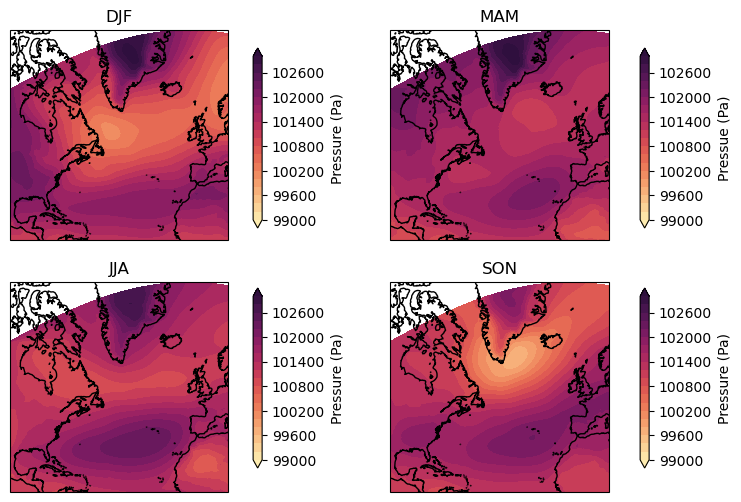

In [8]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

p1 = axes[0][0].contourf(psl_NA_DJF.geolon_t, psl_NA_DJF.geolat_t, psl_NA_DJF[1:4].mean('time'), levels = np.linspace(0.99e5, 1.03e5, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[0][1].contourf(psl_NA_MAM.geolon_t, psl_NA_MAM.geolat_t, psl_NA_MAM[0:3].mean('time'), levels = np.linspace(0.99e5, 1.03e5, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[1][0].contourf(psl_NA_JJA.geolon_t, psl_NA_JJA.geolat_t, psl_NA_JJA[0:3].mean('time'), levels = np.linspace(0.99e5, 1.03e5, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p4 = axes[1][1].contourf(psl_NA_SON.geolon_t, psl_NA_SON.geolat_t, psl_NA_SON[0:3].mean('time'), levels = np.linspace(0.99e5, 1.03e5, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressure (Pa)', fontsize = 10)
axes[0][0].set_title('DJF')

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue (Pa)', fontsize = 10)
axes[0][1].set_title('MAM')

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressure (Pa)', fontsize = 10)
axes[1][0].set_title('JJA')

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressure (Pa)', fontsize = 10)
axes[1][1].set_title('SON')

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

In [18]:
psl_NA_DJF_mean = psl_NA_DJF.mean('time')
psl_NA_DJF_amly = psl_NA_DJF - psl_NA_DJF_mean

psl_NA_MAM_mean = psl_NA_MAM.mean('time')
psl_NA_MAM_amly = psl_NA_MAM - psl_NA_MAM_mean

psl_NA_JJA_mean = psl_NA_JJA.mean('time')
psl_NA_JJA_amly = psl_NA_JJA - psl_NA_JJA_mean

psl_NA_SON_mean = psl_NA_SON.mean('time')
psl_NA_SON_amly = psl_NA_SON - psl_NA_SON_mean

In [19]:
coslat = np.cos(np.deg2rad(psl_NA_DJF.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]

In [20]:
solver_DJF_psl = Eof(psl_NA_DJF_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_DJF_psl = solver_DJF_psl.eofsAsCovariance(neofs = neofs)

solver_MAM_psl = Eof(psl_NA_MAM_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_MAM_psl = solver_MAM_psl.eofsAsCovariance(neofs = neofs)

solver_JJA_psl = Eof(psl_NA_JJA_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_JJA_psl = solver_JJA_psl.eofsAsCovariance(neofs = neofs)

solver_SON_psl = Eof(psl_NA_SON_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_SON_psl = solver_SON_psl.eofsAsCovariance(neofs = neofs)

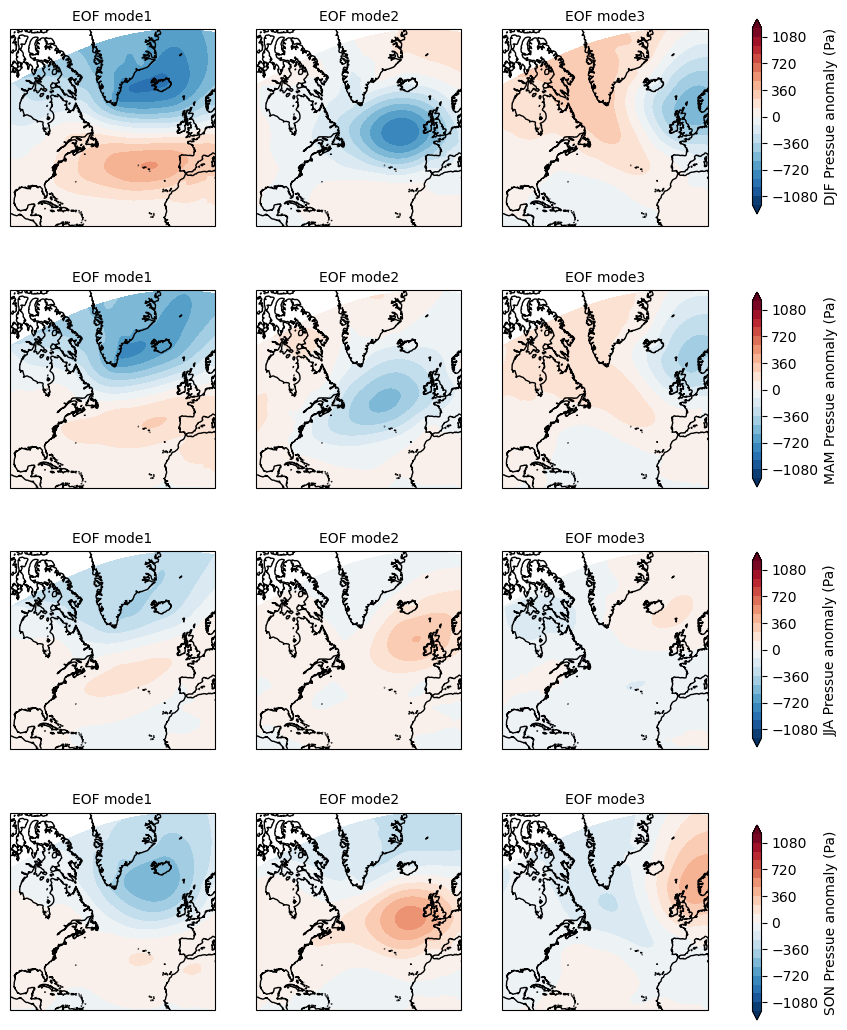

In [11]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (9, 13), subplot_kw = {'projection': projection})

## DJF
p1 = axes[0][0].contourf(psl_NA_DJF.geolon_t, psl_NA_DJF.geolat_t, eof_DJF_psl[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[0][1].contourf(psl_NA_DJF.geolon_t, psl_NA_DJF.geolat_t, eof_DJF_psl[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[0][2].contourf(psl_NA_DJF.geolon_t, psl_NA_DJF.geolat_t, eof_DJF_psl[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

## MAM
p2 = axes[1][0].contourf(psl_NA_MAM.geolon_t, psl_NA_MAM.geolat_t, eof_MAM_psl[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[1][1].contourf(psl_NA_MAM.geolon_t, psl_NA_MAM.geolat_t, eof_MAM_psl[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[1][2].contourf(psl_NA_MAM.geolon_t, psl_NA_MAM.geolat_t, eof_MAM_psl[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

## JJA
p3 = axes[2][0].contourf(psl_NA_JJA.geolon_t, psl_NA_JJA.geolat_t, eof_JJA_psl[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[2][1].contourf(psl_NA_JJA.geolon_t, psl_NA_JJA.geolat_t, eof_JJA_psl[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[2][2].contourf(psl_NA_JJA.geolon_t, psl_NA_JJA.geolat_t, eof_JJA_psl[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

## SON
p4 = axes[3][0].contourf(psl_NA_SON.geolon_t, psl_NA_SON.geolat_t, eof_SON_psl[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[3][1].contourf(psl_NA_SON.geolon_t, psl_NA_SON.geolat_t, eof_SON_psl[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

axes[3][2].contourf(psl_NA_SON.geolon_t, psl_NA_SON.geolat_t, eof_SON_psl[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')


cax = plt.axes([0.95, 0.73, 0.01, 0.15])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('DJF Pressue anomaly (Pa)', fontsize = 10)

cax = plt.axes([0.95, 0.52, 0.01, 0.15])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('MAM Pressue anomaly (Pa)', fontsize = 10)

cax = plt.axes([0.95, 0.32, 0.01, 0.15])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('JJA Pressue anomaly (Pa)', fontsize = 10)

cax = plt.axes([0.95, 0.11, 0.01, 0.15])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('SON Pressue anomaly (Pa)', fontsize = 10)

for i in range(3):
    for j in range(4):
        axes[j][i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[j][i].coastlines(resolution = '50m')
        axes[j][i].set_title('EOF mode' + str(i+1), fontsize = 10)

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA_EOF_modes.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

In [12]:
# Fraction
print('Percentage of EOF explained by first ' + str(neigs) + ' mode for DJF:' + str(
    100 * np.round(solver_DJF_psl.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 mode for DJF:[41.77 22.18 12.36]


In [13]:
# Fraction
print('Percentage of EOF explained by first ' + str(neigs) + ' mode for MAM:' + str(
    100 * np.round(solver_MAM_psl.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 mode for MAM:[40.64 18.71  9.71]


In [14]:
# Fraction
print('Percentage of EOF explained by first ' + str(neigs) + ' mode for JJA:' + str(
    100 * np.round(solver_JJA_psl.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 mode for JJA:[36.469997 15.43      8.84    ]


In [15]:
# Fraction
print('Percentage of EOF explained by first ' + str(neigs) + ' mode for SON:' + str(
    100 * np.round(solver_SON_psl.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 mode for SON:[28.41 22.16 13.93]


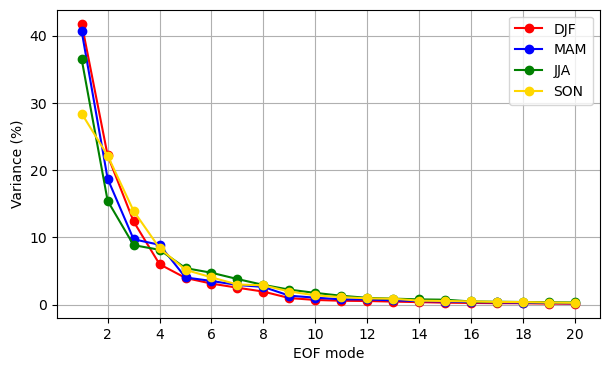

In [17]:
plt.figure(figsize = (7, 4))
plt.plot(np.linspace(1, 20, 20), solver_DJF_psl.varianceFraction(neigs = 20).values * 100, color = 'red', ls = '-', marker = 'o', label = 'DJF')
plt.plot(np.linspace(1, 20, 20), solver_MAM_psl.varianceFraction(neigs = 20).values * 100, color = 'blue', ls = '-', marker = 'o', label = 'MAM')
plt.plot(np.linspace(1, 20, 20), solver_JJA_psl.varianceFraction(neigs = 20).values * 100, color = 'green', ls = '-', marker = 'o', label = 'JJA')
plt.plot(np.linspace(1, 20, 20), solver_SON_psl.varianceFraction(neigs = 20).values * 100, color = 'gold', ls = '-', marker = 'o', label = 'SON')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.grid()
plt.xlabel('EOF mode')
plt.ylabel('Variance (%)')
plt.legend()
#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA_EOF_modes_variances.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

In [21]:
pcs_DJF_psl = solver_DJF_psl.pcs(npcs = npcs, pcscaling = 1)
pcs_MAM_psl = solver_MAM_psl.pcs(npcs = npcs, pcscaling = 1)
pcs_JJA_psl = solver_JJA_psl.pcs(npcs = npcs, pcscaling = 1)
pcs_SON_psl = solver_SON_psl.pcs(npcs = npcs, pcscaling = 1)

## Testing 0.25 degree simulation 

We test the `025deg_jra55_iaf_omip2_cycle4` for NAO signals.

In [12]:
session = cc.database.create_session()
experiment = '025deg_jra55_iaf_omip2_cycle4'

In [13]:
start_time, end_time = '1958-01-01', '2019-12-31'

In [14]:
tauu = cc.querying.getvar(experiment,'tau_x', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

tauu_DJF = tauu.where(tauu.time.dt.month.isin([12, 1, 2]), drop = True)
tauu_NA_DJF = tauu_DJF.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
tauu_MAM = tauu.where(tauu.time.dt.month.isin([3, 4, 5]), drop = True)
tauu_NA_MAM = tauu_MAM.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
tauu_JJA = tauu.where(tauu.time.dt.month.isin([6, 7, 8]), drop = True)
tauu_NA_JJA = tauu_JJA.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
tauu_SON = tauu.where(tauu.time.dt.month.isin([9, 10, 11]), drop = True)
tauu_NA_SON = tauu_SON.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

In [15]:
geolon_c = model_out.geolon_c.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
geolat_c = model_out.geolat_c.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

geolon_t = model_out.geolon_t.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
geolat_t = model_out.geolat_t.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

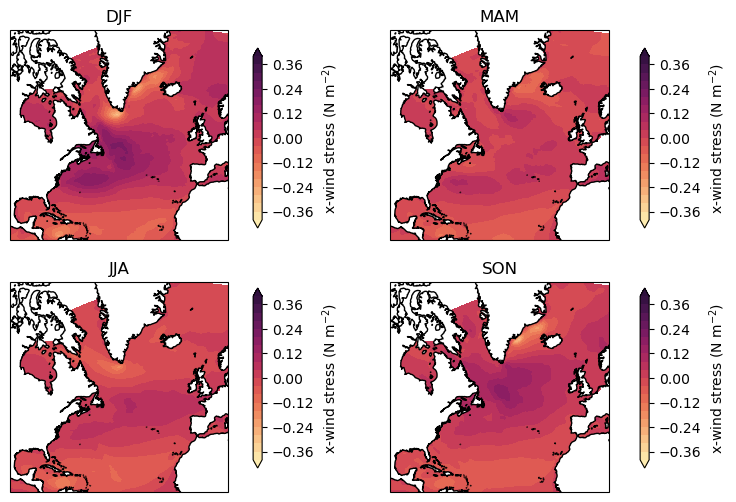

In [16]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

p1 = axes[0][0].contourf(geolon_c, geolat_c, tauu_NA_DJF[2:5].mean('time'), levels = np.linspace(-0.4, 0.4, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[0][1].contourf(geolon_c, geolat_c, tauu_NA_MAM[0:3].mean('time'), levels = np.linspace(-0.4, 0.4, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[1][0].contourf(geolon_c, geolat_c, tauu_NA_JJA[0:3].mean('time'), levels = np.linspace(-0.4, 0.4, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

p4 = axes[1][1].contourf(geolon_c, geolat_c, tauu_NA_SON[0:3].mean('time'), levels = np.linspace(-0.4, 0.4, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[0][0].set_title('DJF')

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[0][1].set_title('MAM')

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[1][0].set_title('JJA')

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[1][1].set_title('SON')

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/pub

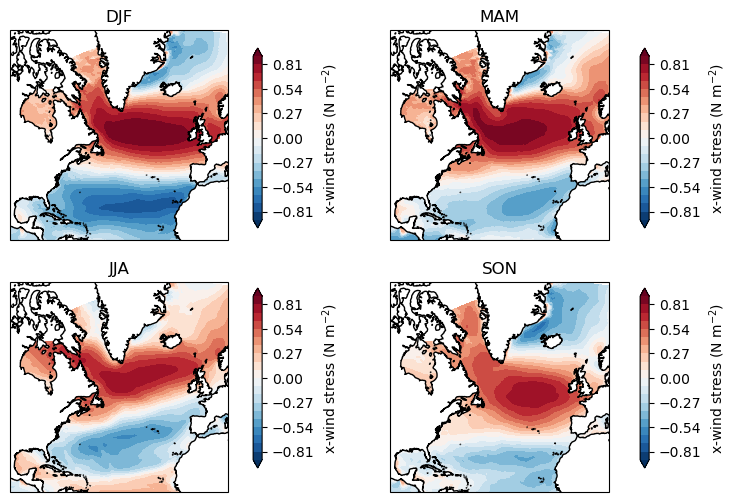

In [22]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = tauu_NA_DJF.time
z = xr.corr(a, tauu_NA_DJF, 'time')
p1 = axes[0][0].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = tauu_NA_MAM.time
z = xr.corr(a, tauu_NA_MAM, 'time')
p2 = axes[0][1].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = tauu_NA_JJA.time
z = xr.corr(a, tauu_NA_JJA, 'time')
p3 = axes[1][0].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = tauu_NA_SON.time
z = xr.corr(a, tauu_NA_SON, 'time')
p4 = axes[1][1].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[0][0].set_title('DJF')

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[0][1].set_title('MAM')

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[1][0].set_title('JJA')

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[1][1].set_title('SON')

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/SLP_NA.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

## NAOi correlation with the curl of wind stress

In [41]:
dtauudy = tauu.differentiate('yu_ocean')*(180/np.pi)/r0
dtauudy_DJF = dtauudy.where(dtauudy.time.dt.month.isin([12, 1, 2]), drop = True)
dtauudy_NA_DJF = dtauudy_DJF.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
dtauudy_MAM = dtauudy.where(dtauudy.time.dt.month.isin([3, 4, 5]), drop = True)
dtauudy_NA_MAM = dtauudy_MAM.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
dtauudy_JJA = dtauudy.where(dtauudy.time.dt.month.isin([6, 7,8]), drop = True)
dtauudy_NA_JJA = dtauudy_JJA.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))
dtauudy_SON = dtauudy.where(dtauudy.time.dt.month.isin([9, 10, 11]), drop = True)
dtauudy_NA_SON = dtauudy_SON.sel(xu_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

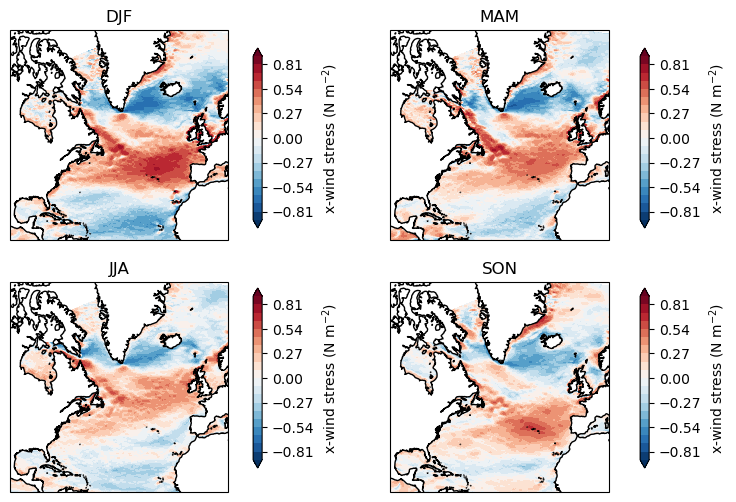

In [42]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 6), subplot_kw = {'projection': projection})

a = pcs_DJF_psl.sel(mode = 0)
a['time'] = dtauudy_NA_DJF.time
z = xr.corr(a, dtauudy_NA_DJF, 'time')
p1 = axes[0][0].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_MAM_psl.sel(mode = 0)
a['time'] = dtauudy_NA_MAM.time
z = xr.corr(a, dtauudy_NA_MAM, 'time')
p2 = axes[0][1].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_JJA_psl.sel(mode = 0)
a['time'] = dtauudy_NA_JJA.time
z = xr.corr(a, dtauudy_NA_JJA, 'time')
p3 = axes[1][0].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

a = pcs_SON_psl.sel(mode = 0)
a['time'] = dtauudy_NA_SON.time
z = xr.corr(a, dtauudy_NA_SON, 'time')
p4 = axes[1][1].contourf(geolon_c, geolat_c, z, levels = np.linspace(-0.9, 0.9, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.45, 0.55, 0.01, 0.3])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[0][0].set_title('DJF')

cax = plt.axes([0.88, 0.55, 0.01, 0.3])
cb = plt.colorbar(p2, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[0][1].set_title('MAM')

cax = plt.axes([0.45, 0.15, 0.01, 0.3])
cb = plt.colorbar(p3, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[1][0].set_title('JJA')

cax = plt.axes([0.88, 0.15, 0.01, 0.3])
cb = plt.colorbar(p4, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)
axes[1][1].set_title('SON')

for i in range(2):
    for j in range(2):
        axes[i][j].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
        axes[i][j].coastlines(resolution = '50m')

## NA gyre strength

In [43]:
tx_trans_int_z = cc.querying.getvar(experiment,'tx_trans_int_z', session, start_time = start_time, end_time = end_time, frequency = '1 monthly', 
                           use_cftime = True).sel(time = slice(start_time, end_time))

#tx_trans_int_z = tx_trans_int_z.where(tx_trans_int_z.time.dt.month.isin([12, 1, 2]), drop = True)
mask = tx_trans_int_z/tx_trans_int_z

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3

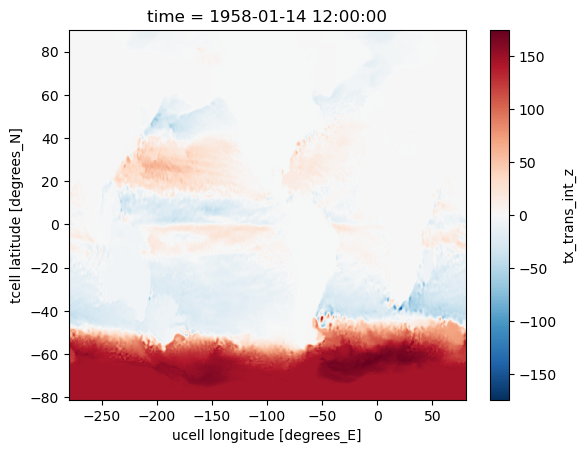

In [44]:
# Calculate barotropic streamfunction
Ψ = -tx_trans_int_z.cumsum('yt_ocean')/(m3_to_Sv * ρ0)
Ψ_ACC = np.nanmin(Ψ.mean('time').sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)))
Ψ_g = Ψ - Ψ_ACC
Ψ_g[0].plot()

In [48]:
# Compute anomalies
Ψ_g_DJF = Ψ_g.where(tx_trans_int_z.time.dt.month.isin([12, 1, 2]), drop = True).sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)) * mask[0]
Ψ_g_DJF_mean = Ψ_g_DJF.mean('time')
Ψ_g_DJF_amly = Ψ_g_DJF - Ψ_g_DJF_mean

Ψ_g_MAM = Ψ_g.where(tx_trans_int_z.time.dt.month.isin([3, 4, 5]), drop = True).sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)) * mask[0]
Ψ_g_MAM_mean = Ψ_g_MAM.mean('time')
Ψ_g_MAM_amly = Ψ_g_MAM - Ψ_g_MAM_mean

Ψ_g_JJA = Ψ_g.where(tx_trans_int_z.time.dt.month.isin([6, 7, 8]), drop = True).sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)) * mask[0]
Ψ_g_JJA_mean = Ψ_g_JJA.mean('time')
Ψ_g_JJA_amly = Ψ_g_JJA - Ψ_g_JJA_mean

Ψ_g_SON = Ψ_g.where(tx_trans_int_z.time.dt.month.isin([9, 10, 11]), drop = True).sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)) * mask[0]
Ψ_g_SON_mean = Ψ_g_SON.mean('time')
Ψ_g_SON_amly = Ψ_g_SON - Ψ_g_SON_mean

## Towards more physically sound correlations

In [49]:
area_t = cc.querying.getvar(experiment, 'area_t', session, frequency = 'static', n = 1)
area_u = cc.querying.getvar(experiment, 'area_u', session, frequency = 'static', n = 1)

In [50]:
area_t = area_t.rename('area-t')
area_u = area_u.rename('area-u')

paths = []
paths.append("/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55_ryf_spinup7_RCP45/output120/ocean/ocean.nc")
data = xr.merge((area_t, area_u))
data.coords['xu_ocean'].attrs.update(axis='X')
data.coords['xt_ocean'].attrs.update(axis='X',c_grid_axis_shift=0.5)
data.coords['yu_ocean'].attrs.update(axis='Y')
data.coords['yt_ocean'].attrs.update(axis='Y',c_grid_axis_shift=0.5)

grid_itp = xgcm.Grid(data, periodic=['X'])
area_t_itp = grid_itp.interp(area_t, 'X')
area_u_itp = grid_itp.interp(area_t, 'Y')

In [52]:
area_t_itp = area_t_itp * (tx_trans_int_z[0]/tx_trans_int_z[0])

In [53]:
area_t_NA = area_t_itp.sel(xu_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
#area_u_NA = area_u_itp.sel(xt_ocean = slice(x_min, x_max)).sel(yu_ocean = slice(y_min, y_max))

In [70]:
Ψ_g_DJF = Ψ_g_DJF.chunk(dict(yt_ocean = 400, xu_ocean = 441))
Ψ_g_MAM = Ψ_g_MAM.chunk(dict(yt_ocean = 400, xu_ocean = 441))
Ψ_g_JJA = Ψ_g_JJA.chunk(dict(yt_ocean = 400, xu_ocean = 441))
Ψ_g_SON = Ψ_g_SON.chunk(dict(yt_ocean = 400, xu_ocean = 441))

In [66]:
area_t_normalize = preprocessing.normalize(area_t_NA.fillna(0))
area_t_normalize = area_t_normalize * (area_t_NA/area_t_NA)
area_t_normalize = area_t_normalize.chunk(dict(yt_ocean = 400, xu_ocean = 441))
Ψ_g_mag_DJF = Ψ_g_DJF.weighted(area_t_normalize.fillna(0)).quantile(0.95, dim = {"yt_ocean", "xu_ocean"})/(m3_to_Sv * ρ0)

In [67]:
Ψ_g_mag_MAM = Ψ_g_MAM.weighted(area_t_normalize.fillna(0)).quantile(0.95, dim = {"yt_ocean", "xu_ocean"})/(m3_to_Sv * ρ0)

In [68]:
Ψ_g_mag_JJA = Ψ_g_JJA.weighted(area_t_normalize.fillna(0)).quantile(0.95, dim = {"yt_ocean", "xu_ocean"})/(m3_to_Sv * ρ0)

In [71]:
Ψ_g_mag_SON = Ψ_g_SON.weighted(area_t_normalize.fillna(0)).quantile(0.95, dim = {"yt_ocean", "xu_ocean"})/(m3_to_Sv * ρ0)

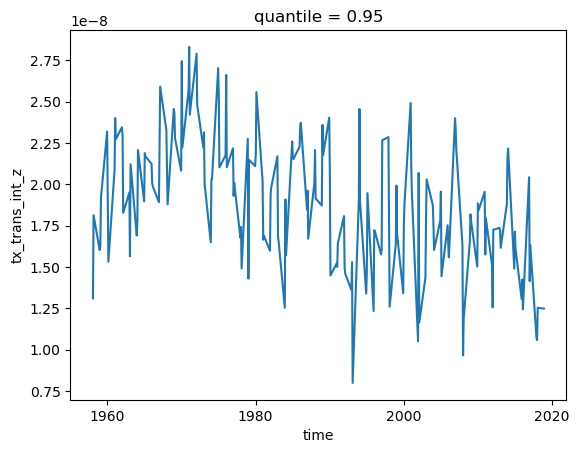

In [73]:
Ψ_g_mag_DJF.plot()

## Regression analysis
Beloew we show maps of correlation coefficient and regression for SLP's first EOF, aka the NAOi and the barotropic streamfunction for each season. This will tell us how much the NAOi is driving the gyre for each season, and whether the correlation is significant or not. 

In [74]:
# Function that linearly regresses for a given time series
def dpsi_pred_func(a, m, c):
    dpsi_pred = m*a+c
    return dpsi_pred

# List of coordinates to check
x_val = [-60, -60, -40, -40]
y_val = [25, 40, 40, 30]

### 1. DJF

In [76]:
a = pcs_DJF_psl.sel(mode = 0)
b = Ψ_g_DJF
a['time'] = b.time

correlation = xr.corr(a, b, 'time')
regression = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


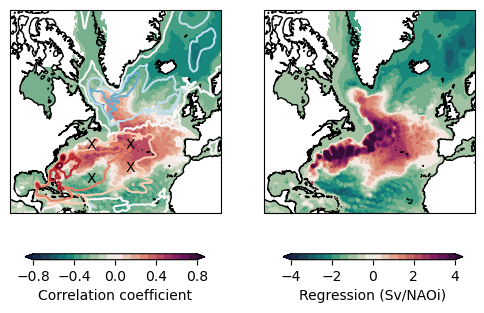

In [77]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(correlation.xu_ocean, correlation.yt_ocean, correlation, levels = np.linspace(-0.8, 0.8, 21), 
                           cmap = cm.cm.curl, transform = ccrs.PlateCarree(), extend = 'both')

axes[0].contour(correlation.xu_ocean, correlation.yt_ocean, Ψ_g_DJF.mean('time'), levels = np.linspace(-30, 30, 9), 
               cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(regression.xu_ocean, regression.yt_ocean, regression, levels = np.linspace(-4, 4, 21), 
             transform = ccrs.PlateCarree(), cmap = cm.cm.curl, extend = 'both')

cax = plt.axes([0.15, 0, 0.3, 0.02])
cb = plt.colorbar(p1, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Correlation coefficient', fontsize = 10)
cb.ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])

cax = plt.axes([0.58, 0, 0.3, 0.02])
cb = plt.colorbar(p2, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Regression (Sv/NAOi)', fontsize = 10)
cb.ax.set_xticks([-4, -2, 0, 2, 4])

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

for i in range(len(x_val)):
    axes[0].text(x = x_val[i], y = y_val[i], s = 'X', color = 'black', transform = ccrs.PlateCarree())

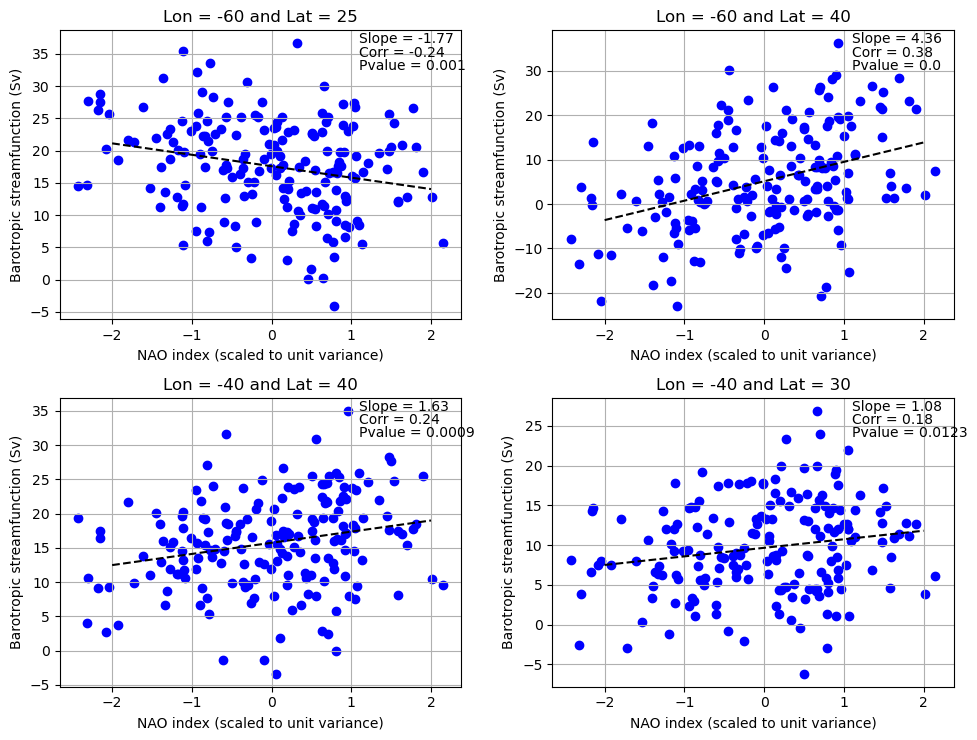

In [79]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 7.5))
for i in range(len(x_val)):

    a = solver_DJF_psl.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_g_DJF.sel(xu_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/2)][int(i%2)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/2)][int(i%2)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/2)][int(i%2)].set_ylabel('Barotropic streamfunction (Sv)')
    axes[int(i/2)][int(i%2)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/2)][int(i%2)].text(1.1, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/2)][int(i%2)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))
    axes[int(i/2)][int(i%2)].grid()

fig.tight_layout()

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Corr_SLPNA_BTgyre_regression.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

### 2. MAM

In [80]:
a = pcs_MAM_psl.sel(mode = 0)
b = Ψ_g_MAM
a['time'] = b.time

correlation = xr.corr(a, b, 'time')
regression = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

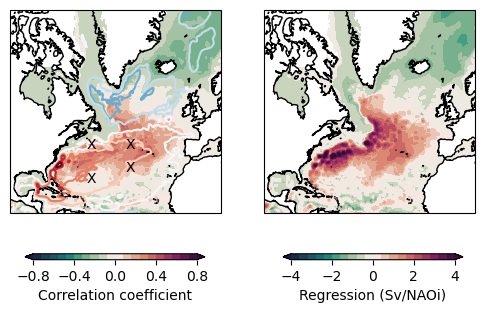

In [81]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(correlation.xu_ocean, correlation.yt_ocean, correlation, levels = np.linspace(-0.8, 0.8, 21), 
                           cmap = cm.cm.curl, transform = ccrs.PlateCarree(), extend = 'both')

axes[0].contour(correlation.xu_ocean, correlation.yt_ocean, Ψ_g_MAM.mean('time'), levels = np.linspace(-30, 30, 9), 
               cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(regression.xu_ocean, regression.yt_ocean, regression, levels = np.linspace(-4, 4, 21), 
             transform = ccrs.PlateCarree(), cmap = cm.cm.curl, extend = 'both')

cax = plt.axes([0.15, 0, 0.3, 0.02])
cb = plt.colorbar(p1, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Correlation coefficient', fontsize = 10)
cb.ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])

cax = plt.axes([0.58, 0, 0.3, 0.02])
cb = plt.colorbar(p2, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Regression (Sv/NAOi)', fontsize = 10)
cb.ax.set_xticks([-4, -2, 0, 2, 4])

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

for i in range(len(x_val)):
    axes[0].text(x = x_val[i], y = y_val[i], s = 'X', color = 'black', transform = ccrs.PlateCarree())

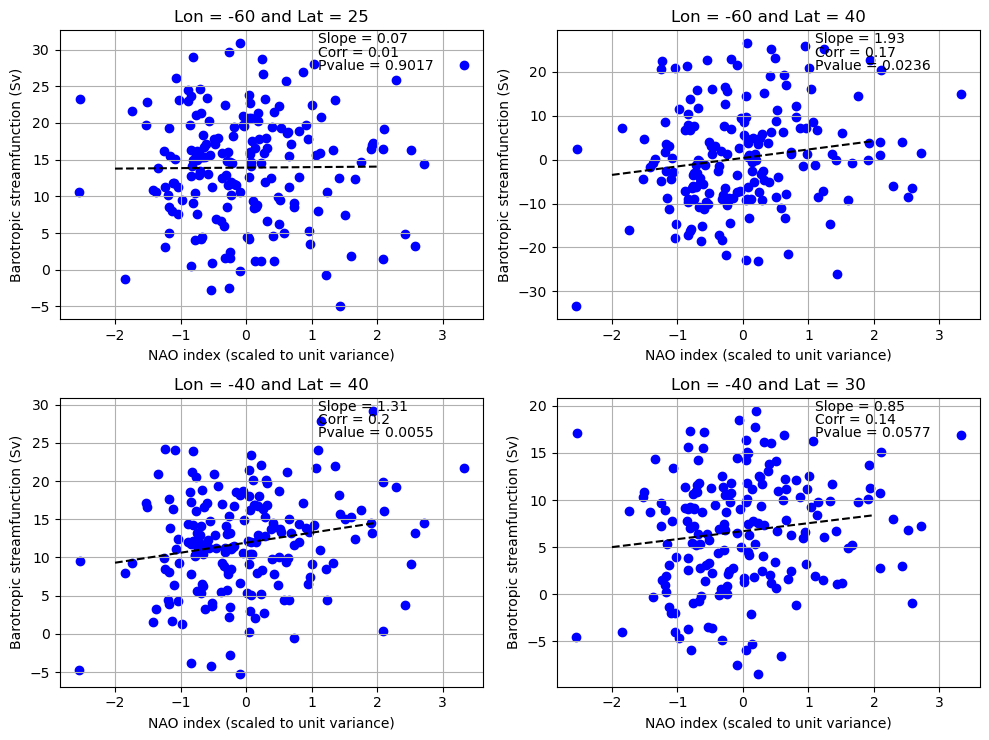

In [82]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 7.5))
for i in range(len(x_val)):

    a = solver_MAM_psl.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_g_MAM.sel(xu_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/2)][int(i%2)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/2)][int(i%2)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/2)][int(i%2)].set_ylabel('Barotropic streamfunction (Sv)')
    axes[int(i/2)][int(i%2)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/2)][int(i%2)].text(1.1, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/2)][int(i%2)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))
    axes[int(i/2)][int(i%2)].grid()

fig.tight_layout()

### 3. JJA

In [83]:
a = pcs_JJA_psl.sel(mode = 0)
b = Ψ_g_JJA
a['time'] = b.time

correlation = xr.corr(a, b, 'time')
regression = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


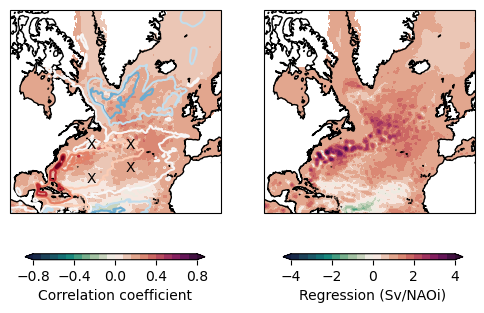

In [84]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(correlation.xu_ocean, correlation.yt_ocean, correlation, levels = np.linspace(-0.8, 0.8, 21), 
                           cmap = cm.cm.curl, transform = ccrs.PlateCarree(), extend = 'both')

axes[0].contour(correlation.xu_ocean, correlation.yt_ocean, Ψ_g_JJA.mean('time'), levels = np.linspace(-30, 30, 9), 
               cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(regression.xu_ocean, regression.yt_ocean, regression, levels = np.linspace(-4, 4, 21), 
             transform = ccrs.PlateCarree(), cmap = cm.cm.curl, extend = 'both')

cax = plt.axes([0.15, 0, 0.3, 0.02])
cb = plt.colorbar(p1, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Correlation coefficient', fontsize = 10)
cb.ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])

cax = plt.axes([0.58, 0, 0.3, 0.02])
cb = plt.colorbar(p2, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Regression (Sv/NAOi)', fontsize = 10)
cb.ax.set_xticks([-4, -2, 0, 2, 4])

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

for i in range(len(x_val)):
    axes[0].text(x = x_val[i], y = y_val[i], s = 'X', color = 'black', transform = ccrs.PlateCarree())

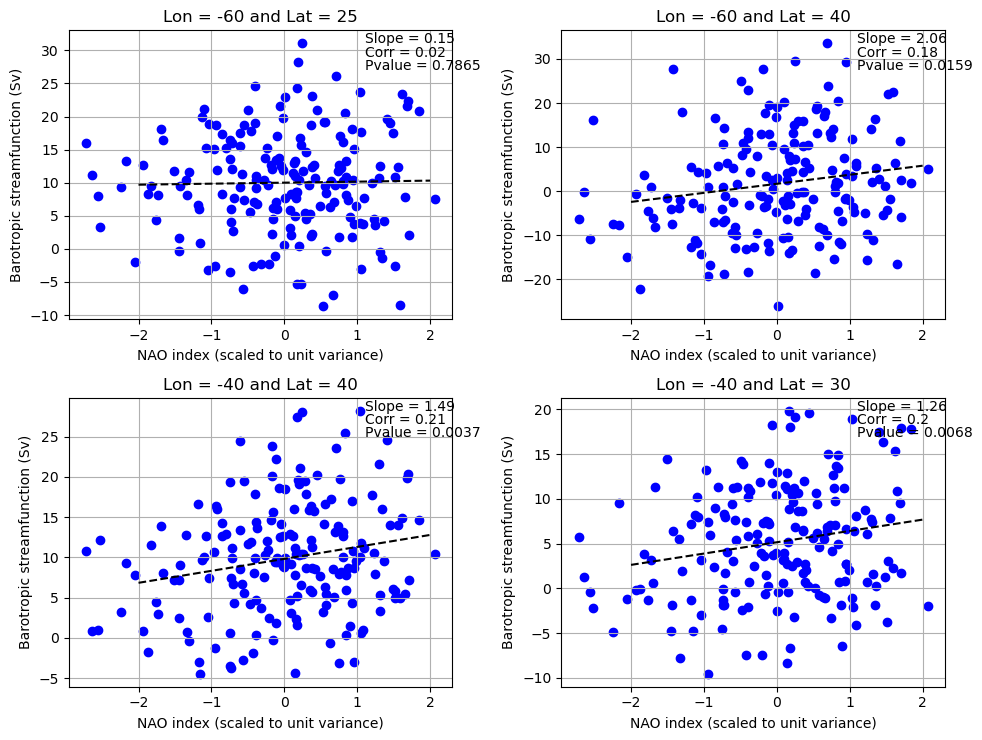

In [85]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 7.5))
for i in range(len(x_val)):

    a = solver_JJA_psl.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_g_JJA.sel(xu_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/2)][int(i%2)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/2)][int(i%2)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/2)][int(i%2)].set_ylabel('Barotropic streamfunction (Sv)')
    axes[int(i/2)][int(i%2)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/2)][int(i%2)].text(1.1, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/2)][int(i%2)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))
    axes[int(i/2)][int(i%2)].grid()

fig.tight_layout()

### 4. SON

In [86]:
a = pcs_SON_psl.sel(mode = 0)
b = Ψ_g_SON
a['time'] = b.time

correlation = xr.corr(a, b, 'time')
regression = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


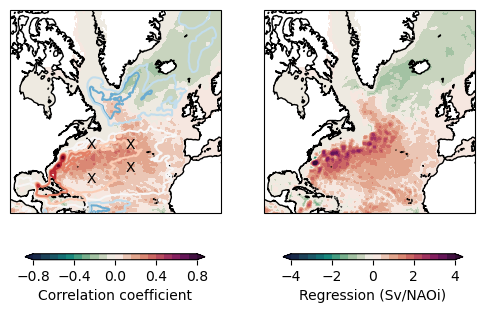

In [87]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(correlation.xu_ocean, correlation.yt_ocean, correlation, levels = np.linspace(-0.8, 0.8, 21), 
                           cmap = cm.cm.curl, transform = ccrs.PlateCarree(), extend = 'both')

axes[0].contour(correlation.xu_ocean, correlation.yt_ocean, Ψ_g_SON.mean('time'), levels = np.linspace(-30, 30, 9), 
               cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(regression.xu_ocean, regression.yt_ocean, regression, levels = np.linspace(-4, 4, 21), 
             transform = ccrs.PlateCarree(), cmap = cm.cm.curl, extend = 'both')

cax = plt.axes([0.15, 0, 0.3, 0.02])
cb = plt.colorbar(p1, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Correlation coefficient', fontsize = 10)
cb.ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])

cax = plt.axes([0.58, 0, 0.3, 0.02])
cb = plt.colorbar(p2, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Regression (Sv/NAOi)', fontsize = 10)
cb.ax.set_xticks([-4, -2, 0, 2, 4])

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

for i in range(len(x_val)):
    axes[0].text(x = x_val[i], y = y_val[i], s = 'X', color = 'black', transform = ccrs.PlateCarree())

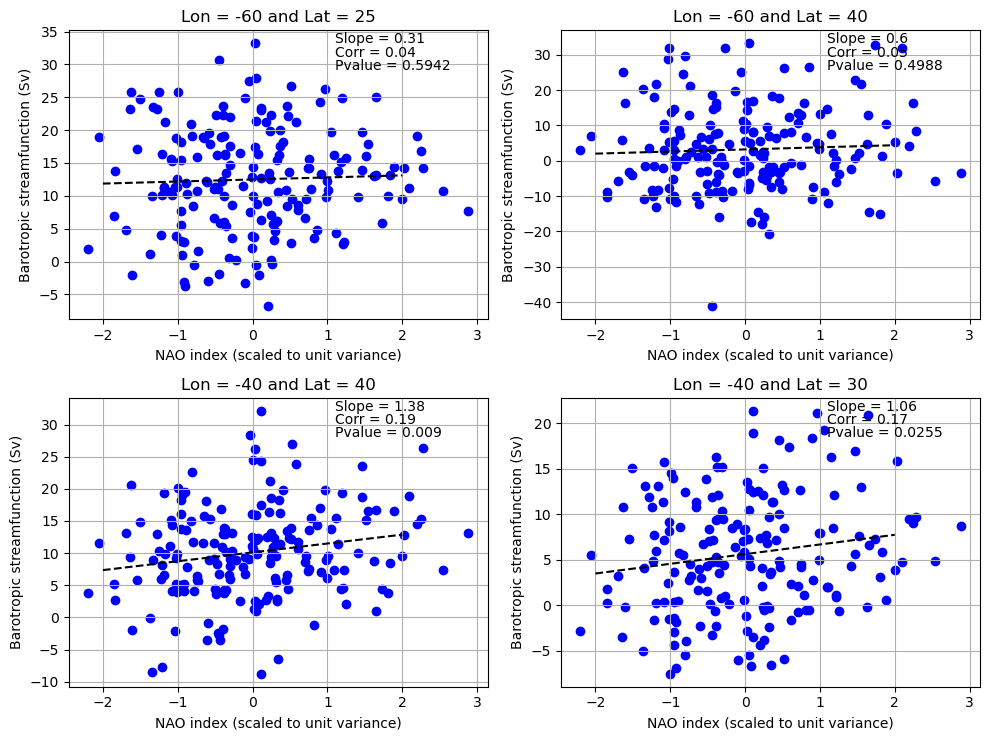

In [88]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 7.5))
for i in range(len(x_val)):

    a = solver_SON_psl.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_g_SON.sel(xu_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/2)][int(i%2)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/2)][int(i%2)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/2)][int(i%2)].set_ylabel('Barotropic streamfunction (Sv)')
    axes[int(i/2)][int(i%2)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/2)][int(i%2)].text(1.1, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/2)][int(i%2)].text(1.1, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/2)][int(i%2)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))
    axes[int(i/2)][int(i%2)].grid()

fig.tight_layout()

### Is there a time-lagged correlation?

In [64]:
Ψ_g_DJF_1mtlag = xr.DataArray(Ψ_g_DJF[1:], coords = [Ψ_g_DJF.time[0:-1], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xu_ocean],  
                              dims = ['time', 'yt_ocean', 'xu_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_g_DJF_1yrlag = xr.DataArray(Ψ_g_DJF[3:], coords = [Ψ_g_DJF.time[0:-3], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xu_ocean],  
                              dims = ['time', 'yt_ocean', 'xu_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_g_DJF_2yrlag = xr.DataArray(Ψ_g_DJF[6:], coords = [Ψ_g_DJF.time[0:-6], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xu_ocean],  
                              dims = ['time', 'yt_ocean', 'xu_ocean'], name = 'Psi', attrs = {'units':'Sv'})

Text(0.5, 1.0, '2 year lag')

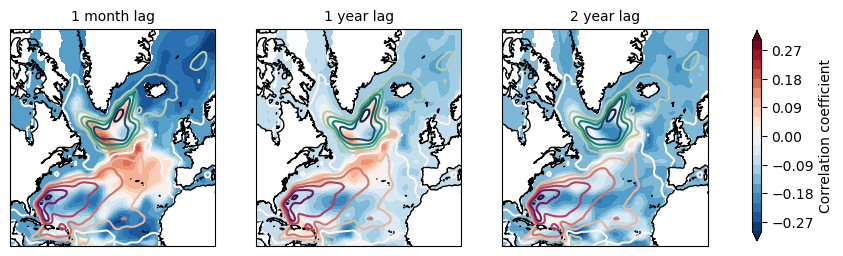

In [65]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

clev = np.linspace(-0.3, 0.3, 21)

a = pcs_SLP_DJF.sel(mode = 0)
a['time'] = Ψ_g_DJF.time

p1 = axes[0].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, xr.corr(a, Ψ_g_DJF_1mtlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, xr.corr(a, Ψ_g_DJF_1yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes[2].contourf(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, xr.corr(a, Ψ_g_DJF_2yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')

for i in range(3):
    axes[i].contour(Ψ_g_DJF.xu_ocean, Ψ_g_DJF.yt_ocean, Ψ_g_DJF.mean('time'), cmap = cm.cm.curl, levels = np.linspace(-30, 30, 11), transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Correlation coefficient', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    
axes[0].set_title('1 month lag', fontsize = 10)
axes[1].set_title('1 year lag', fontsize = 10)
axes[2].set_title('2 year lag', fontsize = 10)

## 0-1100 m depth gyre strength case

In [95]:
a = pcs_SLP_DJF.sel(mode = 0)
b = Ψ_NA/(ρ0 * m3_to_Sv)
a['time'] = b.time

correlation = xr.corr(a, b, 'time')

regression = ((a-a.mean('time'))*(b-b.mean('time'))/a.std('time')).mean('time')

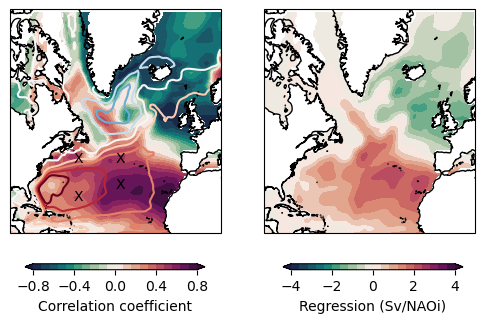

In [97]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (6, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(correlation.xt_ocean, correlation.yu_ocean, correlation, levels = np.linspace(-0.8, 0.8, 21), 
                           cmap = cm.cm.curl, transform = ccrs.PlateCarree(), extend = 'both')

axes[0].contour(correlation.xt_ocean, correlation.yu_ocean, b.mean('time'), levels = np.linspace(-30, 30, 9), 
             transform = ccrs.PlateCarree(), cmap = 'RdBu_r')

p2 = axes[1].contourf(regression.xt_ocean, regression.yu_ocean, regression, levels = np.linspace(-4, 4, 21), 
                     transform = ccrs.PlateCarree(), cmap = cm.cm.curl, extend = 'both')
#Ψ_g_DJF.mean('time').plot.contour(levels = np.linspace(-30, 30, 11), cmap = 'RdBu_r')

#axes.set_xlabel('Longitude ($^{\circ}$E)', transform = ccrs.PlateCarree())
#axes.set_ylabel('Latitude ($^{\circ}$N)', transform = ccrs.PlateCarree())

cax = plt.axes([0.15, 0, 0.3, 0.02])
cb = plt.colorbar(p1, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Correlation coefficient', fontsize = 10)
#cb.ax.set_xticks(['-0.8', '-0.4', '0', '0.4', '0.8'])
cb.ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])

cax = plt.axes([0.58, 0, 0.3, 0.02])
cb = plt.colorbar(p2, cax = cax, orientation = 'horizontal', ax = axes)
cb.ax.set_xlabel('Regression (Sv/NAOi)', fontsize = 10)
cb.ax.set_xticks([-4, -2, 0, 2, 4])

for i in range(2):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')

for i in range(len(x_val)):
    axes[0].text(x = x_val[i], y = y_val[i], s = 'X', color = 'black', transform = ccrs.PlateCarree())

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Corr_SLPNA_BCgyre_map.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

Text(0.5, 1.0, 'Correlation between 0-1100m streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height)')

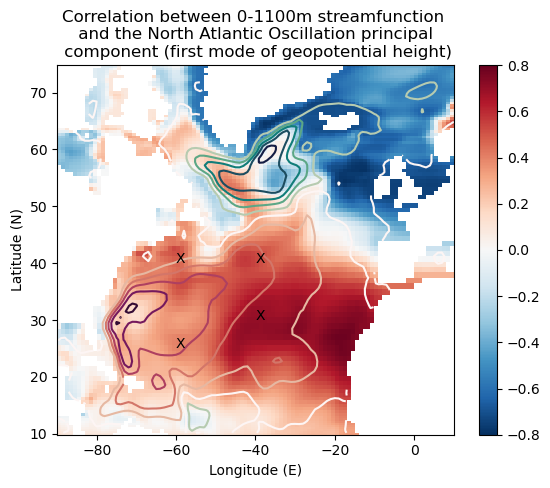

In [68]:
a = pcs_SLP_DJF.sel(mode = 0)
b = Ψ_NA
a['time'] = b.time

xr.corr(a, b, 'time').plot(vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r')

Ψ_g_DJF.mean('time').plot.contour(levels = np.linspace(-30, 30, 11), cmap = cm.cm.curl)
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
for i in range(len(x_val)):
    plt.text(x = x_val[i], y = y_val[i], s = 'X', color = 'black')
plt.title('Correlation between 0-1100m streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height)')

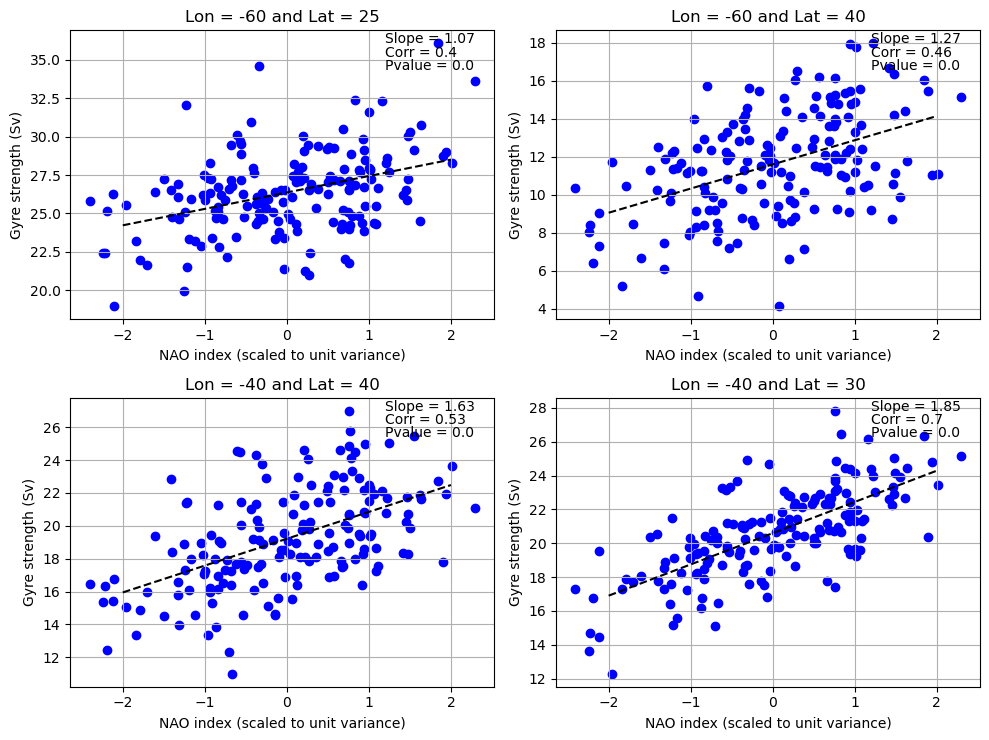

In [69]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 7.5))
for i in range(len(x_val)):

    a = solver_DJF_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_NA.sel(xt_ocean = x_val[i], method = 'nearest').sel(yu_ocean = y_val[i], method = 'nearest').values / (ρ0 * m3_to_Sv)
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/2)][int(i%2)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/2)][int(i%2)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/2)][int(i%2)].set_ylabel('Gyre strength (Sv)')
    axes[int(i/2)][int(i%2)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/2)][int(i%2)].text(1.2, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/2)][int(i%2)].text(1.2, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/2)][int(i%2)].text(1.2, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/2)][int(i%2)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))

    axes[int(i/2)][int(i%2)].grid()
fig.tight_layout()

#plt.savefig('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/Figures/Corr_SLPNA_BCgyre_regression.pdf', bbox_inches = 'tight', 
#            dpi = 300, transparent=True)

### Is there a time-lagged correlation

In [70]:
Ψ_NA_1mtlag = xr.DataArray(Ψ_NA[1:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-1], Ψ_NA.yu_ocean, Ψ_NA.xt_ocean],  
                           dims = ['time', 'yu_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_NA_1yrlag = xr.DataArray(Ψ_NA[3:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-3], Ψ_NA.yu_ocean, Ψ_NA.xt_ocean],  
                           dims = ['time', 'yu_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_NA_2yrlag = xr.DataArray(Ψ_NA[6:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-6], Ψ_NA.yu_ocean, Ψ_NA.xt_ocean],  
                           dims = ['time', 'yu_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})

Text(0.5, 1.0, '2 year lag')

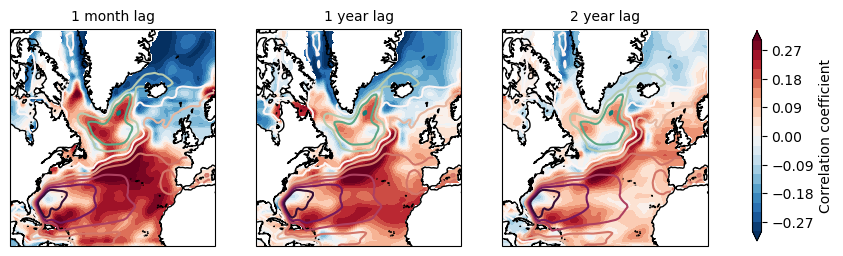

In [71]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

clev = np.linspace(-0.3, 0.3, 21)

a = pcs_SLP_DJF.sel(mode = 0)
a['time'] = Ψ_NA.time

p1 = axes[0].contourf(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, xr.corr(a, Ψ_NA_1mtlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, xr.corr(a, Ψ_NA_1yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes[2].contourf(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, xr.corr(a, Ψ_NA_2yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')

for i in range(3):
    axes[i].contour(Ψ_NA.xt_ocean, Ψ_NA.yu_ocean, Ψ_NA.mean('time')/(ρ0 * m3_to_Sv), cmap = cm.cm.curl, levels = np.linspace(-30, 30, 11), transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Correlation coefficient', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    
axes[0].set_title('1 month lag', fontsize = 10)
axes[1].set_title('1 year lag', fontsize = 10)
axes[2].set_title('2 year lag', fontsize = 10)